In this notebook we will use [Polymake](https://polymake.org/doku.php) to compute the persistent homology of a Vietoris-Rips complex. 

A popular book about these topics is [Computational Topology: An Introduction](https://www.researchgate.net/publication/220692408_Computational_Topology_An_Introduction)  by Herbert Edelsbrunner and John Harer. A shorter introduction with a focus on the algorithms involved can be found in the paper [Computing Persistent Homology](http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.10.5064) by Afra Zomorodian and Gunnar Carlsson. 

After computing persistent homology we will visualize it as a barcode diagram using [Julias](https://julialang.org/) "Plots" package.

In [1]:
versioninfo()

Julia Version 1.4.0
Commit b8e9a9ecc6 (2020-03-21 16:36 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Core(TM) i7-3770 CPU @ 3.40GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-8.0.1 (ORCJIT, ivybridge)


In [1]:
import Pkg
Pkg.activate(".")
Pkg.status()

using Polymake
using Plots 
using Distances

 Activating environment at `~/Desktop/PMJLFork/Polymake.jl/examples/persistent_homology/Project.toml`


Status `~/Desktop/PMJLFork/Polymake.jl/examples/persistent_homology/Project.toml`
  [1f15a43c] CxxWrap v0.10.1
  [b4f34e82] Distances v0.9.0
  [91a5bcdd] Plots v1.3.6
  [d720cf60] Polymake v0.4.2 [`~/.julia/dev/Polymake`]
polymake version 4.0
Copyright (c) 1997-2020
Ewgenij Gawrilow, Michael Joswig, and the polymake team
Technische Universität Berlin, Germany
https://polymake.org

This is free software licensed under GPL; see the source for copying conditions.
There is NO warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



We wil begin by randomly generating a set of points and plotting it, if it is in dimension two or three.

fig = Plot{Plots.GRBackend() n=1}


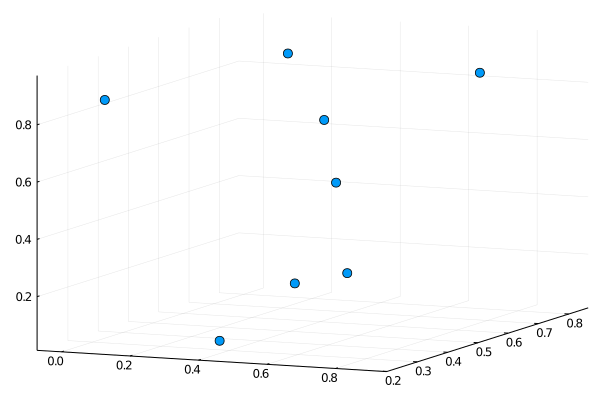

In [2]:
n = 8
dim = 3

points = rand(Float64, (n,dim))

fig = plot()

if dim == 2
    plot!(points[:,1],points[:,2],
    seriestype=:scatter, markersize = 5,legend=false,aspect_ratio =:equal)
    @show fig
end

if dim == 3
    plot!(points[:,1],points[:,2], points[:,3],
        seriestype=:scatter, markersize = 5,legend=false,aspect_ratio =:equal)
    @show fig
end


Let $V = \{v_1,...,v_n\}$ be our vertex set. The Vietoris Rips complex of $V$ with respect to some $\epsilon > 0$ is defined as

$\operatorname{VR}_\epsilon(V) := \{\sigma \subset V \mid \operatorname{dist}(v_i,v_j)\leq \epsilon$, $v_i,v_j \in \sigma\}$

Polymake requires a distance matrix to compute the Vietoris rips complex. Here we use the "Distances" package to compute a $n x n$ matrix of pairwise distances, where $n$ is the number of points. 
We can specify which metric we want to use and choose the Euclidean metric. 

Setting `dims = 1` specifies that we want the pairwise distances of the rows of our matrix `points`.

In [3]:
distances = Distances.pairwise(Distances.Euclidean(),points,dims=1)

8×8 Array{Float64,2}:
 0.0       0.787939  0.461256  0.949579  …  0.892467  0.430361  0.477265
 0.787939  0.0       0.369462  0.296285     0.625871  0.797832  0.757861
 0.461256  0.369462  0.0       0.551528     0.552891  0.632143  0.482414
 0.949579  0.296285  0.551528  0.0          0.546088  0.895457  1.00846
 0.341375  0.545702  0.316362  0.782494     0.86664   0.512323  0.35958
 0.892467  0.625871  0.552891  0.546088  …  0.0       1.03158   0.940508
 0.430361  0.797832  0.632143  0.895457     1.03158   0.0       0.823685
 0.477265  0.757861  0.482414  1.00846      0.940508  0.823685  0.0

To get a filtration we construct Vietoris-Rips complexes with values $\epsilon_i$ which increase by a specified stepwidth in each step. These steps are called __frames__. 

Since all points in our vertex set appear for every $\epsilon > 0$ we need to decide in which frames they should appear in a different manner. To this end we define a `Polymake.Array()` which stores the frame of appearance for each point in vertex set $V$. 
A natural choice is for all to appear in the zeroth frame or in consecutive frames starting at $0$. 


In [4]:
a = Polymake.Array(zeros(Int8,n))

pm::Array<pm::Integer>
0 0 0 0 0 0 0 0

Now we can build the actual filtration via Polymakes __topaz__ module. Along our distance matrix and the specified degrees for the points we pass a stepwidth and another Integer.
This Integer specifies the dimension up to which the VR-complex is computed in each step. 

Afterwards we use anoter function of the __topaz__ module to compute the persistent homology of our filtered complex. 

The output is an array of a list of pairs. Each list represents the homology classes of one dimension in ascending order. Each pair represents one homology class. The values stored in the pairs specify the frame in which the class is born and the frame in which it dies. A value of $-1$ indicates that the homology class is not killed at any point.

In [5]:
filtration = @pm topaz.vietoris_rips_filtration{Rational}(distances, a, 0.1, 4)
pershom = topaz.persistent_homology(filtration)

pm::Array<std::list<std::pair<long, long>, std::allocator<std::pair<long, long> > >>
{(0 3) (0 4) (0 4) (0 4) (0 4) (0 5) (0 6) (0 -1)}
{}
{}
{}
{(9 -1) (10 -1) (10 -1) (10 -1) (11 -1) (11 -1) (11 -1) (11 -1) (11 -1) (11 -1) (11 -1) (11 -1) (11 -1) (11 -1) (11 -1) (11 -1) (11 -1) (11 -1) (11 -1) (11 -1) (11 -1)}


Now we extract the highest frame number in which a homology class dies. We need this for our visualization later on.

In [6]:
inf = 0
for i in 1:length(pershom)
    if(length(pershom[i])>0)
        inf = max(inf,maximum(maximum(pershom[i])))
    end
end
inf += 2

13

The next code block converts the information of our `pershom` object into different Julia arrays we will need to plot the diagram. We need different containers for:
* the points we want to plot, inidcating birth and death of homology classes: `x` and `y`
* lines between points, where each line represents the lifetime of a homology class: `lines`
* arrows from a point of birht to infinity: `arrows`
* some purely informative stuff: `breaklines`, `custom_yticks` and `custom_ylabels`

In [7]:
x = []
y = []
lines = []
arrows = []
levels = [0]
breaklines = []
custom_yticks = [0.0]
custom_ylabels = []

level = 1
for (index,dims) in enumerate(pershom)
    for elements in dims
        append!(x,[elements[1]])
        append!(y,[level])
        
        if(elements[2] == -1)
            append!(arrows,[[[elements[1], inf], [level, level]]])
        else 
            append!(x,[elements[2]])
            append!(y,[level])
            append!(lines,[[[elements[1], elements[2]], [level, level]]])
        end
        level+=1
    end
    
    append!(levels,level)
    append!(breaklines,[[[-0.25,inf],[level, level]]])
    append!(custom_ylabels, ["H$(index-1)"])
    level+=1
end

for i in 2:length(levels)
    append!(custom_yticks, levels[i-1] + (levels[i]-levels[i-1])/2)
end

Now we can use the generated information to generate the bardiagram corresponding to our computations. This concludes our tutorial.

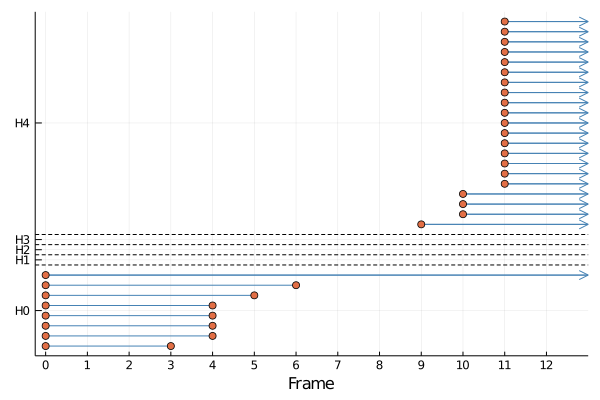

In [8]:
fig = plot()
for line in lines    
    plot!(line[1], line[2], linecolor=:steelblue)
end
for arrow in arrows
    plot!(arrow[1],arrow[2], arrow = true, linecolor=:steelblue)
end
for breakline in breaklines[1:size(breaklines,1)-1]
    plot!(breakline[1],breakline[2], line =:dash, linecolor=:black)
end
scatter!(x,y,xlims = (-0.25,inf),xticks = 0:1:inf-1, yticks = (custom_yticks[2:size(custom_yticks,1)],custom_ylabels), xlabel="Frame",legend=false)
fig

Another popular way of visualizing persistence is to draw a diagram where the $x$ and $y$-axis represent frames and we draw a point $(\operatorname{frame of birth}, \operatorname{frame of death})$ for each homology clas. The homology classes correpsonding to different dimensions are colored differently.

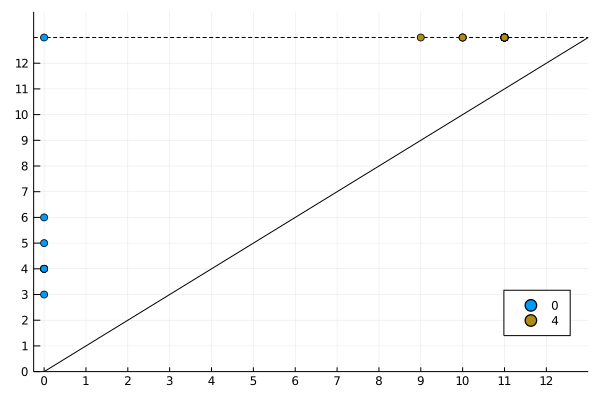

In [35]:
x = []
y = []
fig = plot()
plot!([-0.25,inf],[-0.25,inf], linecolor=:black,label = "")
plot!([-0.25,inf],[inf,inf], line=:dash, linecolor=:black, label = "")

for (id,dims) in enumerate(pershom)
    for (jd,elements) in enumerate(dims)
        #Splitting the scatter draws to only get legend of initial point in each dimension. Very hacky.
        if jd == 1
            if elements[2] == -1
                scatter!([elements.first],[inf],xlims = (-0.25,inf),ylims = (0,inf+1),xticks = 0:1:inf-1, 
                yticks = 0:1:inf-1,label = string(id-1),legend =:bottomright, color=id)
            else
                scatter!([elements.first],[elements.second],xlims = (-0.25,inf),ylims = (0,inf+1),xticks = 0:1:inf-1, 
                yticks = 0:1:inf-1,label = string(id-1),legend =:bottomright, color=id)
            end
        else
            append!(x,elements.first)
            if elements[2] == -1
                append!(y,Int(inf))
            else
                append!(y,Int(elements.second))
            end
        end
        
        
    scatter!(x,y,xlims = (-0.25,inf),ylims = (0,inf+1),xticks = 0:1:inf-1, 
           yticks = 0:1:inf-1,label = "",  color=id)
    
    x = []
    y = []
    end
end

fig